# Cluster Analysis of 2024 MLB batters
This will only get 2024 batters and group them using age, at bats, OPS, exit velocity and sprint speed

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import exploratory as df_f
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import os 
os.chdir('../data_sources')
bat = pd.read_csv('batting_2021_2024.csv', index_col='name')
bat_2024 = bat[bat['year']==2024][['player_age', 'ab', 'on_base_plus_slg', 'exit_velocity_avg', 'sprint_speed']]
bat_2024.head()

,player_age,ab,on_base_plus_slg,exit_velocity_avg,sprint_speed
name,,,,,
"Peralta, David",36,236,0.750,88.1,26.9
"Blackmon, Charlie",37,449,0.741,84.8,27.4
"Maldonado, Martín",37,135,0.404,88.0,23.1
"Solano, Donovan",36,283,0.760,87.3,25.5
"McCutchen, Andrew",37,448,0.739,88.5,26.8


Missings quick check

In [3]:
bat_2024.isna().sum()

player_age            0
ab                    0
on_base_plus_slg      0
exit_velocity_avg     0
sprint_speed         14
dtype: int64

I will remove the 14 players for this case, that's basically players that didn't reach base, usually I treat missings using the methods highlighted [here](https://github.com/danielrferreira/pySETTV/tree/main/03%20-%20Transform/Missing%20Handling).

In [4]:
bat_2024_no_miss = bat_2024[~bat_2024['sprint_speed'].isna()].copy()

As we can see, no more missings:

In [5]:
bat_2024_no_miss.isna().sum()

player_age           0
ab                   0
on_base_plus_slg     0
exit_velocity_avg    0
sprint_speed         0
dtype: int64

Some correlations from the inputs:

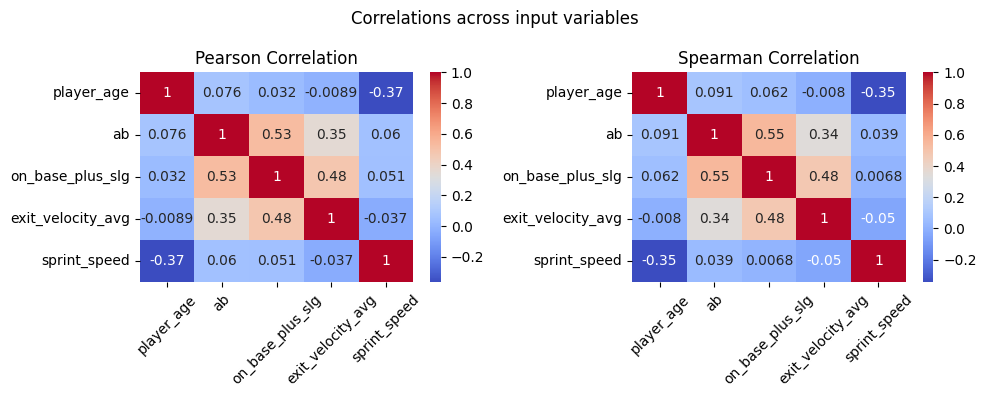

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Correlations across input variables')
axes = axes.flatten()
sns.heatmap(bat_2024_no_miss.corr(),annot=True, cmap='coolwarm', ax = axes[0])
axes[0].set_title('Pearson Correlation')
sns.heatmap(bat_2024_no_miss.corr(method='spearman'),annot=True, cmap='coolwarm', ax = axes[1])
axes[1].set_title('Spearman Correlation')
for ax in axes:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

For some input graphs, I created a class in exploratory.py with some functions:

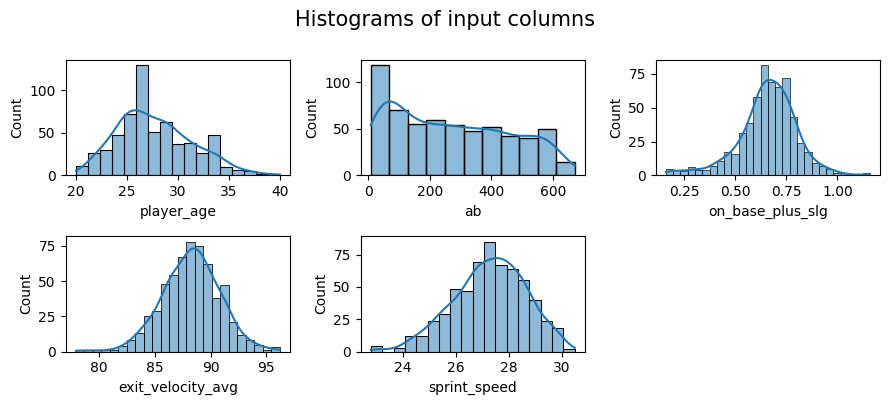

In [7]:
plotter = df_f.multiplot(data=bat_2024_no_miss, x_columns=['player_age','ab','on_base_plus_slg','exit_velocity_avg', 'sprint_speed'])
plotter.hist_plots()

Because the euclidian distances can be more influenced by variables with greater scale, we need to rescale the data. Some people like to rescale the data using sklearn methods, like MinMaxScaler or StandardScaler. I have a list of methods [here](https://github.com/danielrferreira/pySETTV/tree/main/03%20-%20Transform/Standardization). For this case I will use sklearn standardscaler method:

In [8]:
scaler = StandardScaler()
data_standardized = scaler.fit_transform(bat_2024_no_miss)
df = pd.DataFrame(data_standardized)

Let's explore the data to see if there is any natural groups happening. By looking at Within-cluster sum of squares we can see if there is any "elbow" in the curve.

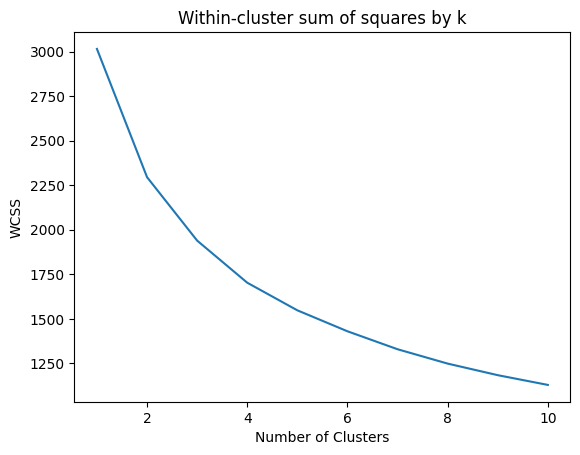

In [9]:
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=100) #n_init is the number of different initial seeds, reduce if your data is large.
    kmeans.fit(data_standardized)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 11), wcss)
plt.title('Within-cluster sum of squares by k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()

No clear number of clusters appear, let's see what PCA shows about how many relevant dimensions we have

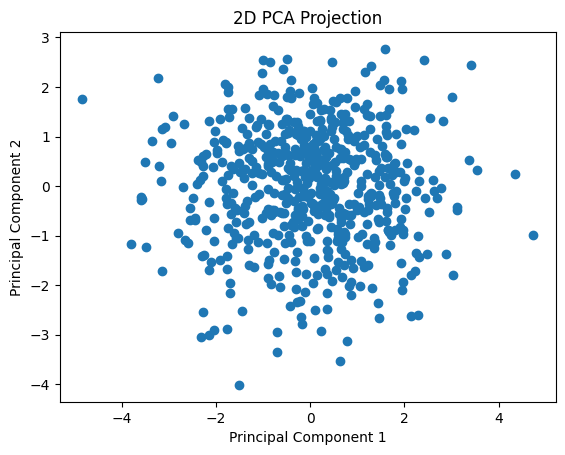

In [10]:
pca = PCA()
data_pca = pca.fit_transform(data_standardized)
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.title('2D PCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Explained variance by PC's:

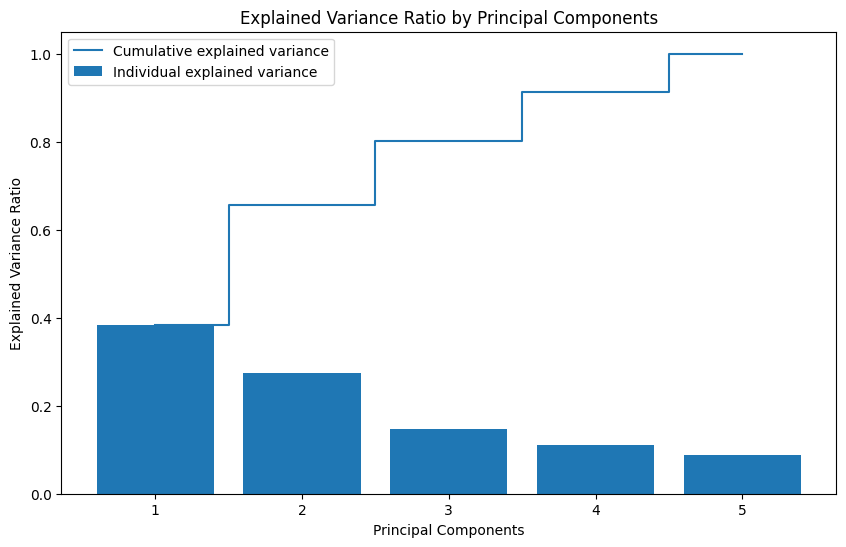

In [11]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center',label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, where='mid',label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.legend()
plt.show()

The previous analysis showed that there is no clear optimal k, in that case we can use a number that is suitable for our business cases. I will proceed with 4 groups just because I think I can handle describing 4 groups.

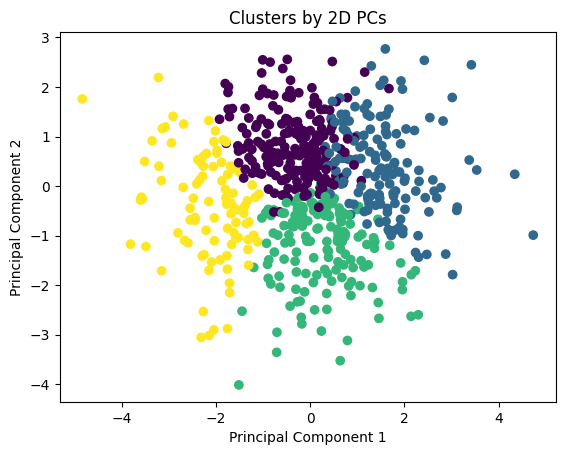

In [12]:
kmeans_final = KMeans(n_clusters=4, init='k-means++', n_init=200)
kmeans_final.fit(df)
df['Cluster'] = kmeans_final.labels_
plt.scatter(data_pca[:, 0], data_pca[:, 1],c=df['Cluster'], cmap='viridis')
plt.title('Clusters by 2D PCs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Frequency of each group

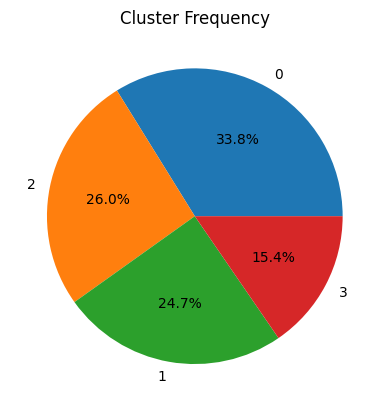

In [13]:
cluster_frequency = df['Cluster'].value_counts()
labels = cluster_frequency.index
sizes = cluster_frequency.values
plt.pie(sizes, labels=labels, autopct=lambda p: '{:.1f}%'.format(p))
plt.title('Cluster Frequency')
plt.show()

Profiling of Clusters. We first need to get the final clusters to the original data (before standardization)

In [14]:
bat_2024_no_miss['Cluster'] = kmeans_final.labels_

Violin Plots of each original input and final cluster


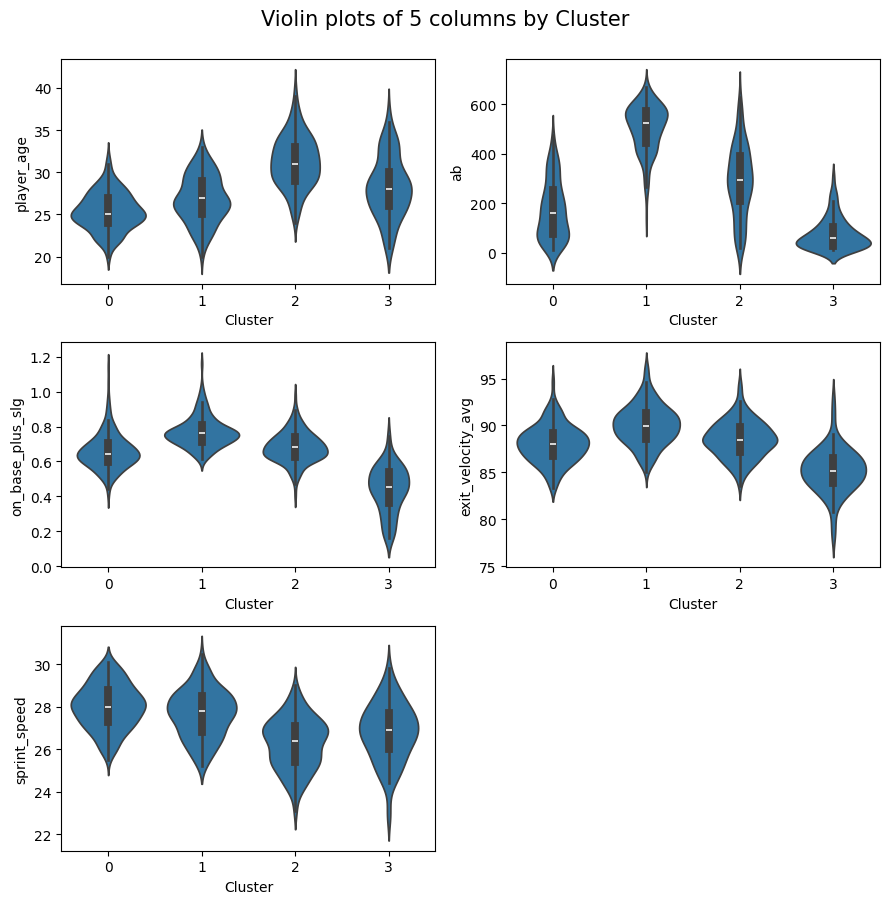

In [15]:
plotter.violin_plots(outcome='Cluster' , n_cols = 2)

Quick look at group 0, which seems to be the OPS beasts:

In [16]:
bat_2024_no_miss[bat_2024_no_miss['Cluster']==0].sort_values('on_base_plus_slg', ascending=False)

,player_age,ab,on_base_plus_slg,exit_velocity_avg,sprint_speed,Cluster
name,,,,,,
"Baker, Darren",25,14,1.143,86.7,26.9,0
"Hinds, Rece",23,46,1.050,91.6,29.2,0
"Acuña, Luisangel",22,39,0.966,91.0,29.5,0
"Call, Alex",29,99,0.950,88.0,28.0,0
"McKenna, Ryan",27,14,0.910,84.5,28.1,0
...,...,...,...,...,...,...
"Lipscomb III, Trey",24,190,0.500,86.5,27.5,0
"Rodriguez, Johnathan",24,31,0.486,91.3,26.8,0
"Bae, Ji Hwan",24,74,0.463,87.3,29.0,0
